

1.   Abiyyu Daffa Haidar Setiawan  1301213519
2.   Hanif Aditia Sofian   1301213550






In [ ]:
import cv2
from sklearn.cluster import KMeans
import pickle
from scipy.spatial.distance import cdist
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn import svm
from skimage import feature
from skimage.color import rgb2gray
from catboost import CatBoostClassifier, Pool


In [ ]:
!gdown --id 12DWmjL6LNLsNye-3o-il-Hw4GDgu6yOh

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=12DWmjL6LNLsNye-3o-il-Hw4GDgu6yOh
From (redirected): https://drive.google.com/uc?id=12DWmjL6LNLsNye-3o-il-Hw4GDgu6yOh&confirm=t&uuid=6997dda5-64d2-4061-bbcf-dd8c558bd892
To: /content/Dataset5000.zip
100% 590M/590M [00:07<00:00, 77.0MB/s]


In [ ]:
!unzip -q /content/Dataset5000.zip -d /content/dataset

## prepare 1000

In [ ]:
import os
import shutil
import tensorflow as tf

# Define your dataset path
dataset_path = "/content/dataset/Dataset5000"
output_path = "/content/dataset/selected_images"

# Create output directories
if not os.path.exists(output_path):
    os.makedirs(output_path)

# Load the dataset
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    image_size=(224, 224),
    batch_size=64,
    label_mode='int',
    shuffle=True,
    seed=42
)

# Get class names
class_names = dataset.class_names

# Process each class
for class_index, class_name in enumerate(class_names):
    class_folder = os.path.join(output_path, class_name)
    if not os.path.exists(class_folder):
        os.makedirs(class_folder)

    # Track the number of images copied
    count = 0

    for images, labels in dataset:
        for i in range(images.shape[0]):
            if count < 100 and labels[i].numpy() == class_index:
                # Save the image
                img = tf.keras.preprocessing.image.array_to_img(images[i])
                img.save(os.path.join(class_folder, f"{class_name}_{count}.jpg"))
                count += 1

            if count >= 100:
                break

        if count >= 100:
            break

print("Images have been saved.")



Found 5968 files belonging to 10 classes.
Images have been saved.


In [ ]:
def load_1000(folder):
    images = []
    labels = []
    class_names = os.listdir(folder)

    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder, class_name)
        if os.path.isdir(class_folder):
            for filename in os.listdir(class_folder):
                img_path = os.path.join(class_folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(label)
    return images, labels

images, labels = load_1000("/content/dataset/selected_images")
print(f"Loaded {len(images)} images with {len(set(labels))} classes.")

Loaded 1000 images with 10 classes.


## Feature extraction

In [ ]:
# def extract_sift_features(list_image):

#     image_descriptors = []
#     sift = cv2.xfeatures2d.SIFT_create()
#     for image in list_image:
#         _, descriptor = sift.detectAndCompute(image, None)
#         image_descriptors.append(descriptor)

#     return image_descriptors
def extract_sift_features(images):
    image_descriptors = []
    keypoints_list = []
    sift = cv2.xfeatures2d.SIFT_create()

    for image in images:
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        keypoints, descriptor = sift.detectAndCompute(image, None)
        image_descriptors.append(descriptor)
        keypoints_list.append(keypoints)

    return image_descriptors, keypoints_list

def kmean(all_descriptors, num_cluster):
    bow_dict = []

    kmeans = KMeans(n_clusters = num_cluster)
    kmeans.fit(all_descriptors)

    bow_dict = kmeans.cluster_centers_

    return bow_dict

def cluster_features(image_descriptors, BoW, num_cluster):

    X_features = []

    for i in range(len(image_descriptors)):
        features = np.array([0] * num_cluster)

        if image_descriptors[i] is not None:
            distance = cdist(image_descriptors[i], BoW)

            argmin = np.argmin(distance, axis = 1)

            for j in argmin:
                features[j] += 1
        X_features.append(features)

    return X_features


def show_sift_keypoints(images, keypoints_list, num_examples=3):
    plt.figure(figsize=(15, 5))
    for i in range(min(num_examples, len(images))):
        image = cv2.cvtColor(images[i], cv2.COLOR_BGR2GRAY)
        img_with_keypoints = cv2.drawKeypoints(image, keypoints_list[i], None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
        plt.subplot(1, num_examples, i + 1)
        plt.imshow(cv2.cvtColor(img_with_keypoints, cv2.COLOR_BGR2RGB))
        plt.title(f'Image {i + 1} Keypoints')
        plt.axis('off')
    plt.show()

In [ ]:
# image_desctiptors = extract_sift_features(images)
image_descriptors, keypoints_list = extract_sift_features(images)

all_descriptors = []
for descriptor in image_descriptors:
    if descriptor is not None:
        for des in descriptor:
            all_descriptors.append(des)

num_cluster = 40
Kmean = kmean(all_descriptors, num_cluster)

X_features = cluster_features(image_descriptors, Kmean, num_cluster)

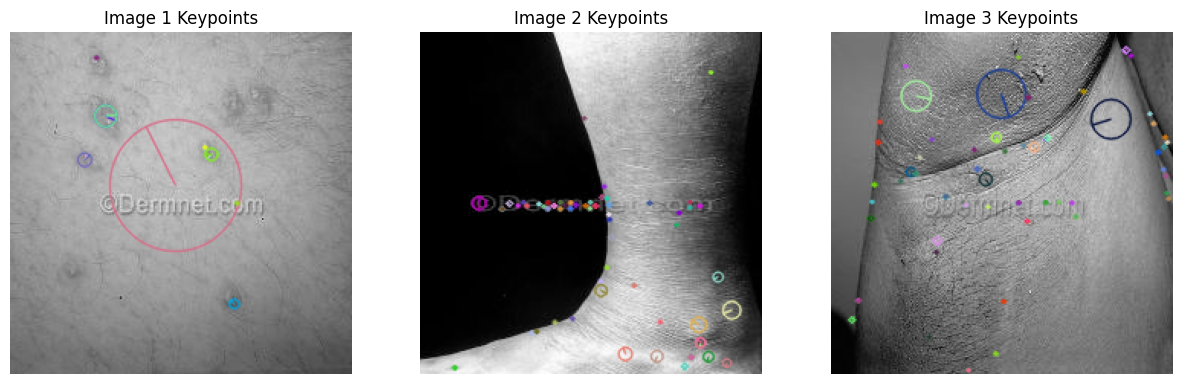

In [ ]:
# show_examples(images, X_features)
show_sift_keypoints(images, keypoints_list)

## Model

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X_features, labels, test_size = 0.2, random_state = 42)
model_svm = svm.SVC(kernel='rbf',C = 40, random_state = 42)

In [ ]:
model_svm.fit(X_train, Y_train)

SVC(C=40, random_state=42)

In [ ]:
y_pred = model_svm.predict(X_test)

accuracy = accuracy_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred, average='weighted')
precision = precision_score(Y_test, y_pred, average='weighted')
recall = recall_score(Y_test, y_pred, average='weighted')

print("Accuracy:", accuracy)
print("F1 Score:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.23
F1 Score: 0.22740551692816907
Precision: 0.2476089635854342
Recall: 0.23


<Figure size 1000x800 with 0 Axes>

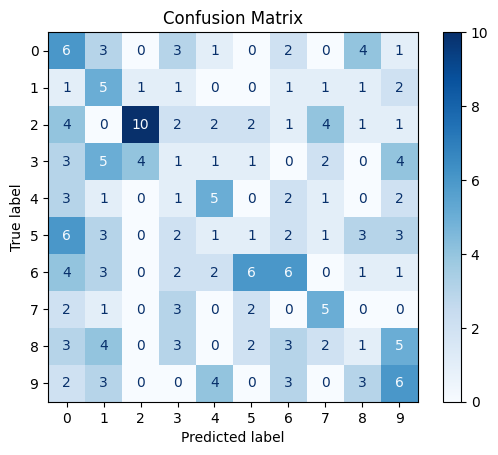

In [ ]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(Y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()